In [1]:
from sklearn import metrics
from random import shuffle
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC 
import seaborn as sns
import  numpy as np
from matplotlib import pyplot as plt
import spacy
import os
import warnings
warnings.filterwarnings("ignore")

C:\Users\Felip\Anaconda3\envs\Text Mining\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
raw_data_path = 'data/semeval-2017-tweets_Subtask-A/downloaded'
path_data = 'data/semeval-2017-tweets_Subtask-A/tweet_data.txt'
path_data_pp = 'data/semeval-2017-tweets_Subtask-A/tweet_data_pre_processed.txt'
path_data_lemma = 'data/semeval-2017-tweets_Subtask-A/tweet_data_lemmatized.txt'

In [3]:
def get_tokens_without_punct(doc):
    return [t for t in doc if t.pos_ not in ['PUNCT', 'SPACE', 'SYM']]

def get_tokens_without_stopwords(doc):
    return [t for t in doc if not t.is_stop]

def get_tokens_as_lemmas(doc):
    return [t.lemma_ for t in doc]

def pre_process(doc):
    doc = get_tokens_without_punct(doc)
    doc = get_tokens_without_stopwords(doc)
    doc = get_tokens_as_lemmas(doc)
    return ' '.join(doc)

In [10]:
# Merge all data
print('Merging data...')
nlp = spacy.load('en_core_web_sm')
for file_ in tqdm(os.listdir(raw_data_path)):
    if file_.endswith(".tsv"):
        path_ = os.path.join(raw_data_path, file_)
        with open(path_,'r', encoding='utf-8') as f, \
            open(path_data,'a') as a, open(path_data_pp,'a') as ap,open(path_data_lemma,'a') as al:
            for tweet in f:
                tweet = tweet.lower()
                tweet = "\t".join(tweet.split("\t")[1:])
                a.write(tweet.replace("\t"," "))
                ap.write(pre_process(nlp(tweet)) + "\n")
                al.write(' '.join(get_tokens_as_lemmas(nlp(tweet))))

SyntaxError: 'continue' not properly in loop (<ipython-input-10-166cafe9f4fd>, line 5)

Tweets: 50333
====== RAW =======
[('neutral', 22591), ('negative', 7839), ('positive', 19903)]
Vocab size: 132752
Average tweet size: 20.112908032503526
Average tweet characters: 106.06180835634673
====== PRE-PROCESSED =======
[('neutral', 22591), ('negative', 7840), ('positive', 19903)]
Vocab size: 75222
Average tweet size: 11.237374339412723
Average tweet characters: 72.40004768148766


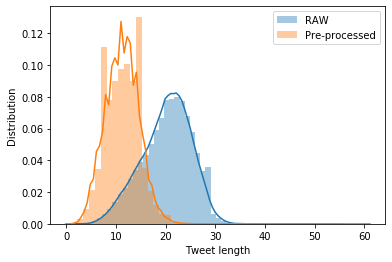

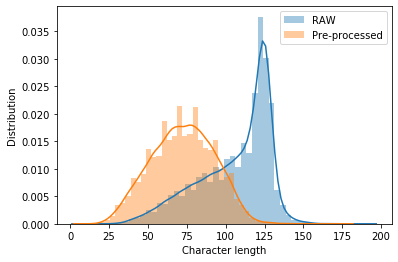

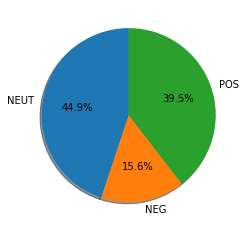

In [4]:
counter = defaultdict(int)
words = set()
lengths = []
lengths_chars = []

counter_pp = defaultdict(int)
words_pp = set()
lengths_pp = []
lengths_chars_pp = []

with open(path_data,'r', encoding='utf-8') as f, open(path_data_pp,'r', encoding='utf-8') as fP:
    for line in f:
        label  = line.split(" ")[0]
        tokens = line.split(" ")[1:]
        words.update(tokens)
        lengths.append(len(tokens))
        counter[label] += 1
        lengths_chars.append(len(line.replace(' ','')))
    for line in fP:
        label  = line.split(" ")[0]
        tokens = line.split(" ")[1:]
        words_pp.update(tokens)
        lengths_pp.append(len(tokens))
        counter_pp[label] += 1
        lengths_chars_pp.append(len(line.replace(' ','')))
print('Tweets:',sum(counter.values()))
print("====== RAW =======")
print(list(counter.items()))
print('Vocab size:',len(words))
print('Average tweet size:',sum(lengths)/len(lengths))
print('Average tweet characters:',sum(lengths_chars)/len(lengths_chars))
print("====== PRE-PROCESSED =======")
print(list(counter_pp.items()))
print('Vocab size:',len(words_pp))
print('Average tweet size:',sum(lengths_pp)/len(lengths_pp))
print('Average tweet characters:',sum(lengths_chars_pp)/len(lengths_chars_pp))
sns.distplot(lengths,label="RAW")
sns.distplot(lengths_pp, label="Pre-processed")
plt.xlabel('Tweet length')
plt.ylabel('Distribution')
plt.legend()
plt.show()
sns.distplot(lengths_chars,label="RAW")
sns.distplot(lengths_chars_pp,label="Pre-processed")
plt.xlabel('Character length')
plt.ylabel('Distribution')
plt.legend()
plt.show()
labels = 'NEUT','NEG','POS'
sizes = [value for value in counter.values()]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

In [14]:
labeled_tweets = []
with open(path_data_pp,'r', encoding='utf-8') as f:
    for tweet in f:
        t  = tweet.split(" ")
        labeled_tweets.append((t[0],t[1:]))
shuffle(labeled_tweets)
tweets = [x for _,x in labeled_tweets]
labels = [y for y,_ in labeled_tweets]

In [15]:
def train_model(data):
    print('Training Doc2Vec model...')
    epochs = 15
    model = Doc2Vec(min_count=3, window=2, size=200)
    model.build_vocab(data)
    model.train(data,total_examples=model.corpus_count,epochs=epochs)
    return model

In [16]:
print('Generating cross-folds...')
split_ratio = (0.8,0.1,0.1) #Train,Dev,Test
cross_folds = int((1-split_ratio[0])**(-1))
print(f'Using {cross_folds} crossfolds...')
assert sum(split_ratio) == 1
cross_fold_items = []
print('Training classifiers...')
for i in range(cross_folds):
    size = len(tweets)
    k1 = i*int(size*split_ratio[1])
    k2 = k1+int(size*split_ratio[1])
    k3 = k2+int(size*split_ratio[2])

    trainD = list(enumerate(tweets[k3:] + tweets[:k1]))
    testD = list(enumerate(tweets[k1:k2]))
    devD = list(enumerate(tweets[k2:k3]))
    print('Generating training data...')
    model_train = train_model([LabeledSentence(tweet,[str(id_)]) for id_,tweet in trainD])
    training_data = np.vstack(model_train[str(id_)] for id_,_ in trainD)
    training_labels = np.hstack(label for label in labels[k3:] + labels[:k1])
    print('Generating test data...')
    model_test =  [model_train.infer_vector(tweet) for id_,tweet in testD]      
    test_data = np.vstack(model_test[id_] for id_,_ in testD)
    test_labels = np.hstack(label for label in labels[k1:k2])
    print('Generating dev data...')
    model_dev =  [model_train.infer_vector(tweet) for id_,tweet in devD]    
    dev_data = np.vstack(model_dev[id_] for id_,_ in devD)
    dev_labels = np.hstack(label for label in labels[k2:k3])
    cross_fold_items.append((training_data,training_labels,test_data,test_labels,dev_data,dev_labels,model_train,model_test,model_dev))
    assert len(test_data) + len(training_data) + len(dev_data) == size

Generating cross-folds...
Using 5 crossfolds...
Training classifiers...
Generating training data...
Training Doc2Vec model...
Generating test data...
Generating dev data...
Generating training data...
Training Doc2Vec model...
Generating test data...
Generating dev data...
Generating training data...
Training Doc2Vec model...
Generating test data...
Generating dev data...
Generating training data...
Training Doc2Vec model...
Generating test data...
Generating dev data...
Generating training data...
Training Doc2Vec model...
Generating test data...
Generating dev data...


In [18]:
print('Classifiers...')
classifiers = [GaussianNB(),LinearSVC(max_iter=100),LogisticRegression(),KNeighborsClassifier()]
np.set_printoptions(suppress=True)
avgs = []
avgs_accs = []
for classifier in classifiers:
    avg = 0.0
    acc = 0.0
    M = np.zeros((3,4))
    print("="*50)
    print(classifier,"\n")
    for i in range(cross_folds):
        training_data,training_labels,test_data,test_labels,dev_data,dev_labels,model_train,model_test,model_dev = cross_fold_items[i]
        classifier.fit(training_data, training_labels)
        y_pred = classifier.predict(test_data)
        report = metrics.classification_report(test_labels, y_pred, target_names=['negative','neutral','positive'],output_dict=True)
        M = M + np.array([list(report['negative'].values()),list(report['neutral'].values()),list(report['positive'].values())])
        print('F1:',metrics.f1_score(test_labels,y_pred,average='macro'))
        print('Accuracy:',metrics.accuracy_score(test_labels,y_pred))
        avg += metrics.f1_score(test_labels,y_pred,average='macro')
        acc += metrics.accuracy_score(test_labels,y_pred)
    avgs.append(avg/cross_folds)
    avgs_accs.append(acc/cross_folds)
    print(((M/5)[:,:-1]).round(3))
    print('AVG:',avgs[-1])
print("#"*25)
print("."*25)
for i in range(len(avgs)):
    print('AVG F1',i,"=",avgs[i])
    print('AVG ACC.',i,"=",avgs_accs[i])

Classifiers...
GaussianNB(priors=None, var_smoothing=1e-09) 

F1: 0.4472073220017803
Accuracy: 0.4728789986091794
F1: 0.324436175024649
Accuracy: 0.3248559507252136
F1: 0.36768477230046
Accuracy: 0.4442678323067753
F1: 0.42030522000197107
Accuracy: 0.4810252334591695
F1: 0.4080006428522414
Accuracy: 0.45857341545797736
[[0.255 0.351 0.27 ]
 [0.552 0.334 0.399]
 [0.479 0.584 0.512]]
AVG: 0.39352682643622033
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0) 

F1: 0.4559159538642256
Accuracy: 0.5334790383469104
F1: 0.4355031613385214
Accuracy: 0.5124180409298629
F1: 0.45079157734039493
Accuracy: 0.5265249354261872
F1: 0.449752185577505
Accuracy: 0.5356646135505663
F1: 0.4411090037669521
Accuracy: 0.5293065765944764
[[0.421 0.145 0.216]
 [0.528 0.645 0.581]
 [0.541 0.546 0.543]]
AVG: 0.44661437637751983
LogisticRe

In [ ]:
classifiers = [GaussianNB(),LinearSVC(max_iter=100),LogisticRegression(),KNeighborsClassifier()]